In [3]:
!pip install vit_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00


Epoch 1/10, Loss: 0.40675005316734314
Epoch 2/10, Loss: 0.08617690950632095
Epoch 3/10, Loss: 0.32247328758239746
Epoch 4/10, Loss: 0.5243183374404907
Epoch 5/10, Loss: 0.5211042761802673
Epoch 6/10, Loss: 0.055811699479818344
Epoch 7/10, Loss: 0.45541149377822876
Epoch 8/10, Loss: 0.708234965801239
Epoch 9/10, Loss: 0.2900681793689728
Epoch 10/10, Loss: 0.06582299619913101


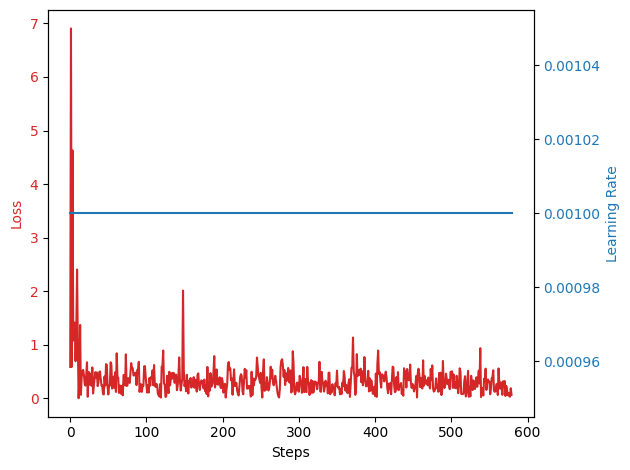

Training complete!


In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from vit_pytorch import ViT
from torch import nn, optim
import matplotlib.pyplot as plt

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 전체 데이터셋 로드
all_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train', transform=transform)

# good과 ng 폴더만 사용하기 위한 인덱스 필터링
filtered_indices = [i for i, (path, label) in enumerate(all_dataset.imgs) if "valid" not in path]
filtered_dataset = torch.utils.data.Subset(all_dataset, filtered_indices)

train_loader = DataLoader(filtered_dataset, batch_size=16, shuffle=True)

# 모델 정의
model = ViT(
    image_size=224,
    patch_size=32,
    num_classes=2,  # good, ng
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1
).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 10
losses = []
lrs = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 손실률과 학습률 저장
        losses.append(loss.item())
        lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# 그래프 그리기
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(lrs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

print("Training complete!")


In [25]:
from pandas.core.dtypes.common import validate_all_hashable
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from vit_pytorch import ViT
import os
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation


# 데이터 로드 및 전처리
path = Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img/train')

# 'valid' 폴더의 이미지 제외
def get_filtered_image_files(path):
    files = get_image_files(path)
    return [f for f in files if 'valid' not in str(f.relative_to(path))]

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_filtered_image_files,  # 수정된 함수 사용
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(256)],
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(
    path,
    bs=16,
    valid_pct=0.2,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224))


# ResNet50과 ViT 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self, n_classes):
        super(EnsembleModel, self).__init__()
        self.resnet50 = create_cnn_model(resnet50, n_out=n_classes)
        self.vit = ViT(
            image_size=224,
            patch_size=32,
            num_classes=n_classes,
            dim=1024,
            depth=6,
            heads=8,
            mlp_dim=2048,
            dropout=0.1,
            emb_dropout=0.1
        )

    def forward(self, x):
        resnet_out = self.resnet50(x)
        vit_out = self.vit(x)
        # 평균 앙상블
        return (resnet_out + vit_out) / 2

model = EnsembleModel(dls.c)
model.cuda()  # GPU로 모델 이동

# Good confidence 60% 이하 판정 수정
def modified_accuracy(inp, targ, axis=-1):
    pred = inp.argmax(dim=axis)
    good_confidence = F.softmax(inp, dim=axis)[:, 1]
    pred[good_confidence <= 0.6] = 0  # 60% 이하면 ng로 판정
    return (pred == targ).float().mean()

# Learner 정의
# learn = Learner(dls, model, metrics=modified_accuracy, cbs=EarlyStoppingCallback(patience=3))
learn = Learner(dls, model,metrics=[accuracy, F1Score(), Recall()], cbs=EarlyStoppingCallback(patience=3))


# 학습
learn.fit_one_cycle(10, 1e-3)


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:282: UserWarning: `create_cnn_model` has been renamed to `create_vision_model` -- please update your code
  warn("`create_cnn_model` has been renamed to `create_vision_model` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.389496,0.151445,0.942029,0.968750,1.000000,00:08
1,0.281455,0.998077,0.898551,0.946565,1.000000,00:06
2,0.385109,0.627232,0.855072,0.913793,0.854839,00:07
3,0.362948,17.573576,0.101449,0.000000,0.000000,00:07


No improvement since epoch 0: early stopping


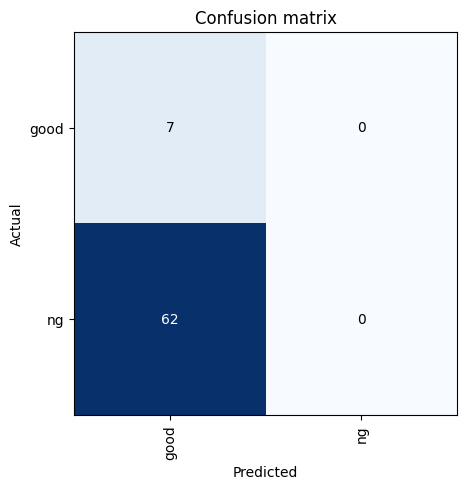

In [26]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

interp.plot_confusion_matrix()

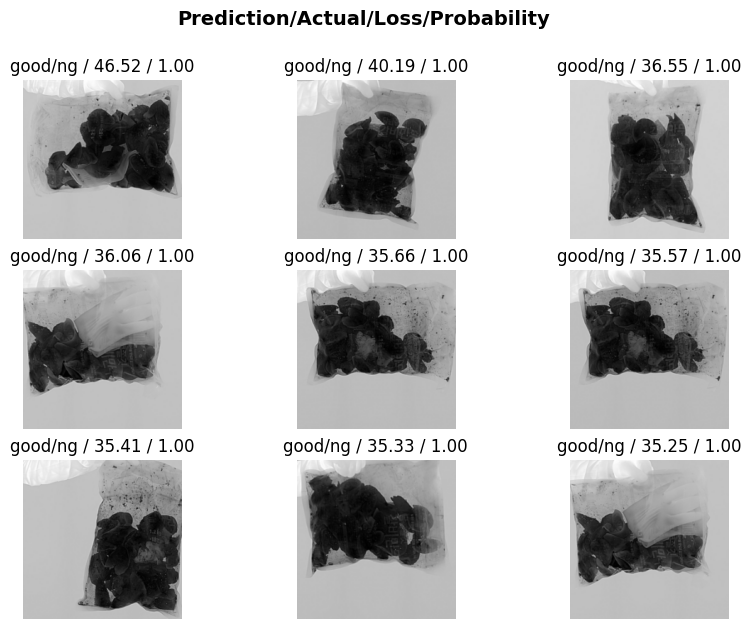

In [24]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [27]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

accuracy: 0.10144927352666855
Recall: 0.0
F1 score: 0.0
